### This example demonstrates the use of experience replay with XCSF
Uses the [cart-pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) problem from OpenAI gymnasium (v.0.28.1)

```
$ pip install gymnasium[classic-control]

```

**Note:** 

These hyperparameters do not result in consistently optimal performance.

Normalising the inputs and reward, and using prioritised experience replay may increase performance.

In [1]:
from __future__ import annotations

import json
import random
from collections import deque

import gymnasium as gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
from matplotlib import rcParams
from tqdm import tqdm

import xcsf

RANDOM_STATE: int = 1010
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

### Initialise OpenAI Gym problem environment

In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset(seed=RANDOM_STATE)

X_DIM: int = int(env.observation_space.shape[0])
N_ACTIONS: int = int(env.action_space.n)

### Initialise XCSF

In [3]:
xcs = xcsf.XCS(
    x_dim=X_DIM,
    y_dim=N_ACTIONS,
    n_actions=1,
    omp_num_threads=12,
    random_state=RANDOM_STATE,
    pop_init=False,
    max_trials=1,  # one trial per fit()
    pop_size=200,
    theta_del=100,
    e0=0.001,
    alpha=1,
    beta=0.05,
    ea={
        "select_type": "roulette",
        "theta_ea": 100,
        "lambda": 2,
    },
    condition={
        "type": "neural",
        "args": {
            "layer_0": {  # hidden layer
                "type": "connected",
                "activation": "selu",
                "evolve_weights": True,
                "evolve_neurons": True,
                "n_init": 1,
                "n_max": 100,
                "max_neuron_grow": 1,
            },
            "layer_1": {  # output layer
                "type": "connected",
                "activation": "linear",
                "evolve_weights": True,
                "n_init": 1,
            },
        },
    },
    prediction={
        "type": "rls_quadratic",
    },
)

GAMMA: float = 0.95  # discount rate for delayed reward
epsilon: float = 1  # initial probability of exploring
EPSILON_MIN: float = 0.1  # the minimum exploration rate
EPSILON_DECAY: float = 0.98  # the decay of exploration after each batch replay
REPLAY_TIME: int = 1  # perform replay update every n episodes

print(json.dumps(xcs.internal_params(), indent=4))

{
    "version": "1.3.0",
    "x_dim": 4,
    "y_dim": 2,
    "n_actions": 1,
    "omp_num_threads": 12,
    "random_state": 1010,
    "population_file": "",
    "pop_init": false,
    "max_trials": 1,
    "perf_trials": 1000,
    "pop_size": 200,
    "loss_func": "mae",
    "set_subsumption": false,
    "theta_sub": 100,
    "e0": 0.001,
    "alpha": 1,
    "nu": 5,
    "beta": 0.05,
    "delta": 0.1,
    "theta_del": 100,
    "init_fitness": 0.01,
    "init_error": 0,
    "m_probation": 10000,
    "stateful": true,
    "compaction": false,
    "ea": {
        "select_type": "roulette",
        "theta_ea": 100,
        "lambda": 2,
        "p_crossover": 0.8,
        "err_reduc": 1,
        "fit_reduc": 0.1,
        "subsumption": false,
        "pred_reset": false
    },
    "condition": {
        "type": "neural",
        "args": {
            "layer_0": {
                "type": "connected",
                "activation": "selu",
                "n_inputs": 4,
                "n_ini

### Execute experiment

In [4]:
total_steps: int = 0  # total number of steps performed
MAX_EPISODES: int = 2000  # maximum number of episodes to run
N: int = 100  # number of episodes to average performance
memory: deque[tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=50000)
scores: deque[float] = deque(maxlen=N)  # used to calculate moving average

# for rendering an episode as a gif
SAVE_GIF: bool = True
SAVE_GIF_EPISODES: int = 50

frames: list[list[float]] = []
fscore: list[float] = []
ftrial: list[int] = []


def replay(replay_size: int = 5000) -> None:
    """Performs experience replay updates"""
    batch_size: int = min(len(memory), replay_size)
    batch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in batch:
        y_target = reward
        if not done:
            prediction_array = xcs.predict(next_state.reshape(1, -1))[0]
            y_target += GAMMA * np.max(prediction_array)
        target = xcs.predict(state.reshape(1, -1))[0]
        target[action] = y_target
        xcs.fit(
            state.reshape(1, -1), target.reshape(1, -1), warm_start=True, verbose=False
        )


def egreedy_action(state: np.ndarray) -> int:
    """Selects an action using an epsilon greedy policy"""
    if np.random.rand() < epsilon:
        return random.randrange(N_ACTIONS)
    prediction_array = xcs.predict(state.reshape(1, -1))[0]
    # break ties randomly
    best_actions = np.where(prediction_array == prediction_array.max())[0]
    return int(np.random.choice(best_actions))


def episode(episode_nr: int, create_gif: bool) -> tuple[float, int]:
    """Executes a single episode, saving to memory buffer"""
    episode_score: float = 0
    episode_steps: int = 0
    state: np.ndarray = env.reset()[0]
    while True:
        action = egreedy_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_steps += 1
        episode_score += reward
        memory.append((state, action, reward, next_state, done))
        if create_gif:
            frames.append(env.render())
            fscore.append(episode_score)
            ftrial.append(episode_nr)
        if done:
            if create_gif:
                for _ in range(100):
                    frames.append(frames[-1])
                    fscore.append(fscore[-1])
                    ftrial.append(ftrial[-1])
            break
        state = next_state
    return episode_score, episode_steps


# learning episodes
for ep in range(MAX_EPISODES):
    gif: bool = False
    if SAVE_GIF and ep % SAVE_GIF_EPISODES == 0:
        gif = True
    # execute a single episode
    ep_score, ep_steps = episode(ep, gif)
    # perform experience replay updates
    if ep % REPLAY_TIME == 0:
        replay()
    # display performance
    total_steps += ep_steps
    scores.append(ep_score)
    mean_score = np.mean(scores)
    print(
        f"episodes={ep} "
        f"steps={total_steps} "
        f"score={mean_score:.2f} "
        f"epsilon={epsilon:.5f} "
        f"error={xcs.error():.5f} "
        f"msize={xcs.mset_size():.2f}"
    )
    # is the problem solved?
    if ep > N and mean_score > env.spec.reward_threshold:
        print(
            f"solved after {ep} episodes: "
            f"mean score {mean_score:.2f} > {env.spec.reward_threshold:.2f}"
        )
        break
    # decay the exploration rate
    if epsilon > EPSILON_MIN:
        epsilon *= EPSILON_DECAY

episodes=0 steps=29 score=29.00 epsilon=1.00000 error=0.77227 msize=0.99
episodes=1 steps=45 score=22.50 epsilon=0.98000 error=1.39253 msize=1.00
episodes=2 steps=75 score=25.00 epsilon=0.96040 error=1.70605 msize=3.00
episodes=3 steps=91 score=22.75 epsilon=0.94119 error=1.28962 msize=5.00
episodes=4 steps=132 score=26.40 epsilon=0.92237 error=1.61216 msize=7.00
episodes=5 steps=144 score=24.00 epsilon=0.90392 error=3.13718 msize=10.82
episodes=6 steps=155 score=22.14 epsilon=0.88584 error=1.86810 msize=13.00
episodes=7 steps=167 score=20.88 epsilon=0.86813 error=1.65494 msize=16.99
episodes=8 steps=202 score=22.44 epsilon=0.85076 error=1.39431 msize=21.00
episodes=9 steps=223 score=22.30 epsilon=0.83375 error=1.61573 msize=25.00
episodes=10 steps=241 score=21.91 epsilon=0.81707 error=1.97849 msize=29.45
episodes=11 steps=256 score=21.33 epsilon=0.80073 error=1.10901 msize=34.55
episodes=12 steps=274 score=21.08 epsilon=0.78472 error=1.49194 msize=40.64
episodes=13 steps=289 score=20.

episodes=107 steps=8181 score=80.14 epsilon=0.11513 error=0.13155 msize=183.23
episodes=108 steps=8312 score=81.10 epsilon=0.11283 error=0.14032 msize=163.98
episodes=109 steps=8481 score=82.58 epsilon=0.11057 error=0.69085 msize=181.22
episodes=110 steps=8714 score=84.73 epsilon=0.10836 error=0.18798 msize=127.59
episodes=111 steps=8817 score=85.61 epsilon=0.10619 error=0.51595 msize=152.29
episodes=112 steps=8932 score=86.58 epsilon=0.10407 error=0.17651 msize=197.06
episodes=113 steps=9195 score=89.06 epsilon=0.10199 error=0.16473 msize=178.62
episodes=114 steps=9449 score=91.47 epsilon=0.09995 error=0.26321 msize=181.75
episodes=115 steps=9718 score=94.01 epsilon=0.09995 error=0.25563 msize=151.52
episodes=116 steps=10072 score=97.37 epsilon=0.09995 error=0.17509 msize=177.99
episodes=117 steps=10350 score=99.91 epsilon=0.09995 error=0.17174 msize=162.91
episodes=118 steps=10650 score=102.81 epsilon=0.09995 error=0.33484 msize=189.72
episodes=119 steps=11072 score=106.92 epsilon=0.

episodes=209 steps=53776 score=452.95 epsilon=0.09995 error=0.04956 msize=183.14
episodes=210 steps=54276 score=455.62 epsilon=0.09995 error=0.04252 msize=189.74
episodes=211 steps=54776 score=459.59 epsilon=0.09995 error=0.04523 msize=189.02
episodes=212 steps=55276 score=463.44 epsilon=0.09995 error=0.03444 msize=187.42
episodes=213 steps=55776 score=465.81 epsilon=0.09995 error=0.03401 msize=168.78
episodes=214 steps=56276 score=468.27 epsilon=0.09995 error=0.02691 msize=191.72
episodes=215 steps=56776 score=470.58 epsilon=0.09995 error=0.02983 msize=193.18
episodes=216 steps=57276 score=472.04 epsilon=0.09995 error=0.04898 msize=177.08
episodes=217 steps=57776 score=474.26 epsilon=0.09995 error=0.02964 msize=188.71
episodes=218 steps=58276 score=476.26 epsilon=0.09995 error=0.03078 msize=180.95
solved after 218 episodes: mean score 476.26 > 475.00


### Final exploit episode

In [5]:
epsilon = 0
ep_score, ep_steps = episode(ep, SAVE_GIF)
print(f"score = {ep_score}, steps = {ep_steps}")

score = 500.0, steps = 500


### Render the learning episodes

In [6]:
annotated_frames = []

if SAVE_GIF:
    # add score and episode nr
    rcParams["font.family"] = "monospace"
    bbox = {"boxstyle": "round", "fc": "0.8"}
    bar = tqdm(total=len(frames), position=0, leave=True)
    for i in range(len(frames)):
        fig = plt.figure(dpi=90)
        fig.set_size_inches(3, 3)
        ax = fig.add_subplot(111)
        plt.imshow(frames[i])
        plt.axis("off")
        strial = str(ftrial[i])
        sscore = str(int(fscore[i]))
        text = f"episode = {strial:3s}, score = {sscore:3s}"
        ax.annotate(text, xy=(0, 100), xytext=(-40, 1), fontsize=12, bbox=bbox)
        fig.canvas.draw()
        annotated_frames.append(np.asarray(fig.canvas.renderer.buffer_rgba()))
        plt.close(fig)
        bar.refresh()
        bar.update(1)
    bar.close()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2221/2221 [00:38<00:00, 57.69it/s]


In [7]:
if SAVE_GIF:
    imageio.mimsave("animation.gif", annotated_frames, duration=30)

In [8]:
!gifsicle -O3 --colors=64 --use-col=web --lossy=100 --crop 0,10-270,220 --output out.gif animation.gif

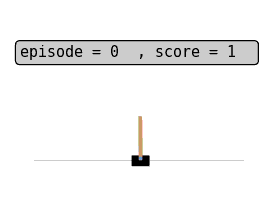

In [9]:
if SAVE_GIF:
    display(Image(open("out.gif", "rb").read()))

In [10]:
env.close()  # close Gym